In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio

import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
hex_gdf = gpd.read_file('../data/processed/cerro_garcia/hex_amc_utm_v1.geojson')
print(hex_gdf.shape)
hex_gdf.head(2)

(133846, 21)


,hex_id_11,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,...,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos,idx_riesgos,geometry
0,8b49aa34355cfff,0.117143,0.686519,0.416667,1.0,0.5,0.546560,1.0,0.97116,1.0,...,0.500,1.0,0.124227,0.495735,0.655952,1.00,0.000000,0.011816,0.502330,"POLYGON ((656968.694 2246226.723, 656986.582 2..."
1,8b49aa04e0b6fff,0.352821,0.407454,0.416667,0.5,0.5,0.437385,0.0,1.00000,1.0,...,0.169,1.0,0.173280,0.733339,0.523116,0.75,0.001259,0.200000,0.510475,"POLYGON ((685155.909 2226765.182, 685173.793 2..."


## K-means model

In [5]:
hex_gdf = hex_gdf.fillna(0)

In [6]:
data = hex_gdf.drop(columns=['hex_id_11','geometry']).to_numpy()

In [7]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(data, hex_gdf[['idx_valor_recursos_naturales']].to_numpy(), test_size = 0.35)

In [ ]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(4, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    print(k,silhouette_score(data, cluster_labels))
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

4 0.23790962190718953


In [7]:
# 9 categorías de zonificación

kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([4, 5, 0, ..., 0, 4, 2], dtype=int32)

<AxesSubplot: >

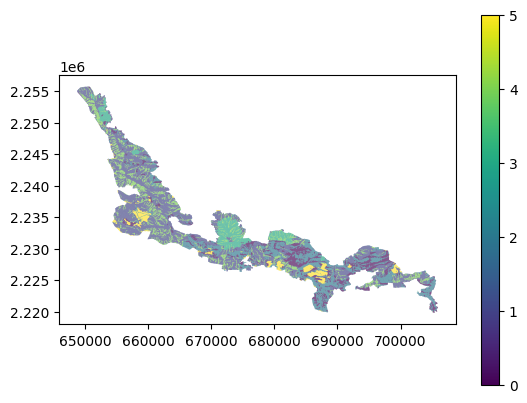

In [8]:
hex_gdf['cluster'] = clusters
hex_gdf.plot('cluster', legend=True)

In [9]:
hex_gdf.groupby('cluster').mean()

/tmp/ipykernel_39679/2509220162.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hex_gdf.groupby('cluster').mean()


,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos,idx_riesgos
cluster,,,,,,,,,,,,,,,,,,,
0,0.162280,0.534397,0.380389,0.995220,0.5,0.510460,0.031031,0.979000,0.998307,0.669000,0.466629,0.999175,0.187365,0.914678,0.642877,0.918324,0.016393,0.203708,0.575209
1,0.153281,0.629850,0.419619,0.994338,0.5,0.538236,0.981948,0.984406,0.998264,0.988569,0.497820,0.999786,0.184644,0.751631,0.666296,0.982857,0.004731,0.010767,0.581286
2,0.144493,0.581776,0.387194,0.993795,0.5,0.519150,0.023761,0.974141,0.999400,0.665384,0.488091,0.998795,0.190269,0.568860,0.652939,0.934547,0.015898,0.207342,0.459806
3,0.153587,0.723238,0.419090,0.999723,0.5,0.558685,0.993039,0.991655,0.995927,0.993608,0.495912,0.997363,0.209370,0.728531,0.662539,0.947470,0.357468,0.005676,0.692993
4,0.166611,0.649791,0.417215,0.996268,0.5,0.545100,0.985127,0.990528,0.998416,0.991592,0.508762,0.999768,0.187974,0.354141,0.670981,0.987361,0.031129,0.007493,0.460795
5,0.133847,0.469165,0.399678,0.529759,0.5,0.402444,0.017344,0.984885,0.998834,0.666639,0.408889,0.977486,0.175036,0.755769,0.614708,0.897255,0.003775,0.202799,0.518709


In [12]:
hex_gdf.groupby('cluster').std()

/tmp/ipykernel_39679/1937231481.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hex_gdf.groupby('cluster').std()


,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,idx_aprovechamiento_cultural,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos,idx_riesgos
cluster,,,,,,,,,,,,,,,,,,,
0,0.109558,0.117207,0.105629,0.028593,0.0,0.064976,0.096947,0.063376,0.014341,0.038287,0.108048,0.013150,0.035338,0.090261,0.048597,0.145488,0.066017,0.033011,0.038927
1,0.093735,0.093552,0.119664,0.046713,0.0,0.052058,0.072803,0.050686,0.015581,0.029894,0.074311,0.005091,0.034761,0.134782,0.029832,0.073173,0.022668,0.027205,0.046438
2,0.089843,0.109347,0.100175,0.037362,0.0,0.054775,0.084287,0.066210,0.008607,0.034444,0.093202,0.018081,0.035146,0.164973,0.044187,0.132602,0.064497,0.033066,0.058935
3,0.089429,0.077644,0.088426,0.010858,0.0,0.041540,0.046522,0.028545,0.023799,0.020518,0.033404,0.017333,0.046178,0.153424,0.048606,0.150054,0.153868,0.017104,0.074047
4,0.090234,0.087074,0.110717,0.036516,0.0,0.047100,0.068888,0.034406,0.016258,0.026575,0.081311,0.003589,0.036685,0.142631,0.029425,0.060122,0.088661,0.022125,0.052758
5,0.079141,0.081335,0.110832,0.066263,0.0,0.057739,0.075538,0.053707,0.014102,0.029746,0.156008,0.077785,0.025396,0.192628,0.065420,0.131412,0.026417,0.025127,0.066491


In [11]:
hex_gdf.groupby('cluster').count()

,hex_id_11,idx_hidrologia,idx_coberturavegetal,idx_biodiversidad,idx_politica,idx_edafologia,idx_valor_recursos_naturales,idx_agricola,idx_pertenencia,idx_recreativo,...,idx_degradacion_cobertura_vegetal,idx_cambio_ndvi,idx_impacto_antropogenico,idx_erosion,idx_degradacion,idx_erosion_potencial,idx_incendios,idx_proximidad_entornos_urbanos,idx_riesgos,geometry
cluster,,,,,,,,,,,,,,,,,,,,,
0,17778,17778,17778,17778,17778,17778,17778,17778,17778,17778,...,17778,17778,17778,17778,17778,17778,17778,17778,17778,17778
1,51936,51936,51936,51936,51936,51936,51936,51936,51936,51936,...,51936,51936,51936,51936,51936,51936,51936,51936,51936,51936
2,29065,29065,29065,29065,29065,29065,29065,29065,29065,29065,...,29065,29065,29065,29065,29065,29065,29065,29065,29065,29065
3,9545,9545,9545,9545,9545,9545,9545,9545,9545,9545,...,9545,9545,9545,9545,9545,9545,9545,9545,9545,9545
4,19542,19542,19542,19542,19542,19542,19542,19542,19542,19542,...,19542,19542,19542,19542,19542,19542,19542,19542,19542,19542
5,5980,5980,5980,5980,5980,5980,5980,5980,5980,5980,...,5980,5980,5980,5980,5980,5980,5980,5980,5980,5980


In [13]:
import seaborn as sns

/tmp/ipykernel_39679/3621437363.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.heatmap(hex_gdf.groupby('cluster').mean(),


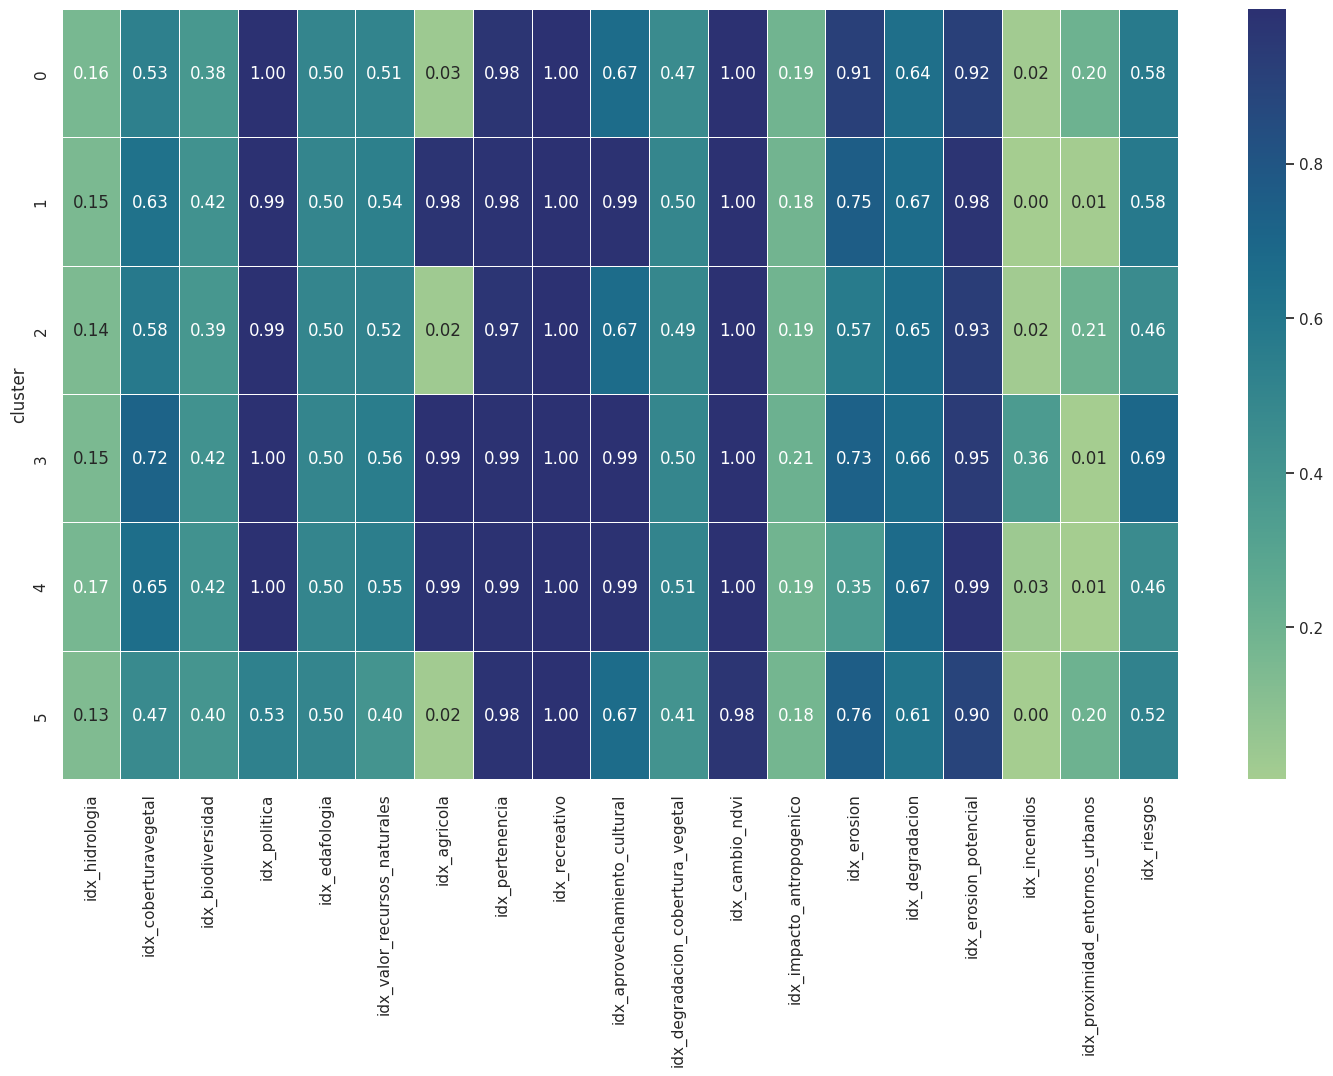

In [36]:
sns.heatmap(hex_gdf.groupby('cluster').mean(), 
            annot=True,fmt=".2f", linewidth=.5, cmap="crest")
sns.set (rc = {'figure.figsize':(18, 10)})

In [17]:
hex_gdf.to_file('../data/processed/cerro_garcia/hex_cluster_cerro_garcia.geojson')